### Импорт библиотек

In [12]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
# import logging


### Глобальные настройки

In [13]:
warnings.filterwarnings("ignore", category=UserWarning)

load_dotenv()

# logging.basicConfig()
# logging.getLogger('sqlalchemy.engine').setLevel(logging.INFO)

True

#### Создаем DataFrame-ы из предоставленных данных `Final_proj`

In [14]:
df_companing = pd.read_csv('../datasets/Final_proj/companing.csv')
df_sendings = pd.read_csv('../datasets/Final_proj/sendings.csv')
df_response = pd.read_csv('../datasets/Final_proj/response.csv')
df_sales = pd.read_csv('../datasets/Final_proj/sales.csv')
df_price = pd.read_csv('../datasets/Final_proj/price.csv')

display(df_companing.head(1))
print('-'*100)
display(df_sendings.head(1))
print('-'*100)
display(df_response.head(1))
print('-'*100)
display(df_sales.head(1))
print('-'*100)
display(df_price.head(1))
print('-'*100)


,campaning_SD,Start_date,response_period,description
0,camp_3581,2023-06-23,3,А_Б тест макета банера в письме


----------------------------------------------------------------------------------------------------


,campaning_SD,send_name,cell_package_sk,communication_SK,subject
0,camp_3581,23_06_2023_win_prize_A,118512,808600,Выиграй приз при любой покупке!


----------------------------------------------------------------------------------------------------


,Id_customer,response_code,cell_package_sk
0,2917,1,118512


----------------------------------------------------------------------------------------------------


,Date,Id_customer,id_product
0,2023-07-03 00:00:00,2917,6


----------------------------------------------------------------------------------------------------


,product_id,price
0,1,40


----------------------------------------------------------------------------------------------------


#### С помощью `sqlalchemy` заполняем базу данными из `DataFrame`-ов
- Создание движка
- Создание новой схемы
- Загрузка данных в базу

In [15]:
# Смотрел логи не мог понять почему происходит ROLBACK и схема не создавалась в базе
# Пришлось сомому управлять этой транзакцией и вызывать ROLBACK только в случае ошибок...

url_object = URL.create("postgresql",
                        username=os.getenv('DB_USER'),
                        password=os.getenv('DB_PASSWORD'),
                        host=os.getenv('DB_HOST'),
                        port=os.getenv('DB_PORT'),
                        database=os.getenv('DB_NAME'))

engine = create_engine(url_object)

with engine.connect() as con:
    trans = con.begin()
    try:
        con.execute(text("CREATE SCHEMA IF NOT EXISTS final_02;"))
        trans.commit()
    except Exception as e:
        trans.rollback()


df_companing.to_sql('companing', engine, schema='final_02', if_exists='replace', index=False)
df_sendings.to_sql('sendings', engine, schema='final_02', if_exists='replace', index=False)
df_response.to_sql('response', engine, schema='final_02', if_exists='replace', index=False)
df_sales.to_sql('sales', engine, schema='final_02', if_exists='replace', index=False)
df_price.to_sql('price', engine, schema='final_02', if_exists='replace', index=False)

21

#### Подключаемся к базе с помощью `psycopg2`

In [16]:
conn = psycopg2.connect(host=os.getenv('DB_HOST'),
                        port=os.getenv('DB_PORT'),
                        dbname=os.getenv('DB_NAME'),
                        user=os.getenv('DB_USER'),
                        password=os.getenv('DB_PASSWORD'),
                        options="-c search_path=final_02,public")

#### Повторный просмотр данных , уже из БД

In [17]:
df_companing = pd.read_sql('SELECT * FROM "final_02"."companing"', conn)
df_sendings = pd.read_sql('SELECT * FROM "final_02"."sendings"', conn)
df_response = pd.read_sql('SELECT * FROM "final_02"."response"', conn)
df_sales = pd.read_sql('SELECT * FROM "final_02"."sales"', conn)
df_price = pd.read_sql('SELECT * FROM "final_02"."price"', conn)

display(df_companing.head(1))
print('-'*100)
display(df_sendings.head(1))
print('-'*100)
display(df_response.head(1))
print('-'*100)
display(df_sales.head(1))
print('-'*100)
display(df_price.head(1))
print('-'*100)


,campaning_SD,Start_date,response_period,description
0,camp_3581,2023-06-23,3,А_Б тест макета банера в письме


----------------------------------------------------------------------------------------------------


,campaning_SD,send_name,cell_package_sk,communication_SK,subject
0,camp_3581,23_06_2023_win_prize_A,118512,808600,Выиграй приз при любой покупке!


----------------------------------------------------------------------------------------------------


,Id_customer,response_code,cell_package_sk
0,2917,1,118512


----------------------------------------------------------------------------------------------------


,Date,Id_customer,id_product
0,2023-07-03 00:00:00,2917,6


----------------------------------------------------------------------------------------------------


,product_id,price
0,1,40


----------------------------------------------------------------------------------------------------


#### Запрос в БД
- `combined_table` - Подзапрс , объеденяем таблицы

- `select_sum_count_resp` - Подзапрс, считаем `response`, `count_people`, `summa_purchase` 
    - `response` - Количество людей, совершивших покупку
    - `count_people` - Количество людей в группе 
    - `summa_purchase` - Сумму покупок по группам
    
- Основной запрос - Считаем `response_rate`
    - `response_rate` - Доля откликов в  группуе

In [18]:
df_request_to_bd = pd.read_sql(
    """
     WITH combined_table AS (
          SELECT "comp"."campaning_SD"     AS company,
                 "comp"."Start_date"       AS start_data,
                 "comp"."response_period"  AS period,
                 "send"."send_name"        AS send_name,
                 "send"."communication_SK" AS connection,
                 "send"."cell_package_sk"  AS number_group,
                 "resp"."response_code"    AS code,
                 "resp"."Id_customer"      AS id_people,
                 "sale"."Date"             AS date,
                 "sale"."id_product"       AS id_product,
                 "pric"."price"            AS price
            FROM companing AS comp
                 JOIN sendings AS send USING("campaning_SD")
                 JOIN response AS resp ON "send"."cell_package_sk" = "resp"."cell_package_sk"
                      AND "resp"."response_code" IN (1, 3)
                 LEFT JOIN sales AS sale ON "resp"."Id_customer" = "sale"."Id_customer"
                      AND "sale"."Date":: timestamp BETWEEN "comp"."Start_date":: timestamp AND "comp"."Start_date":: timestamp + INTERVAL '3 day'
                 LEFT JOIN price AS pric ON "pric"."product_id" = "sale"."id_product"),

          select_sum_count_resp AS(
          SELECT company,
                 send_name,
                 connection,
                 code,
                 COUNT(DISTINCT CASE
                                WHEN "date" IS NOT NULL THEN "id_people"
                                END) AS response,
                 COUNT(DISTINCT id_people) AS count_people,
                 SUM(price) AS summa_purchase
            FROM combined_table
           GROUP BY send_name, code, company, connection
           ORDER BY company DESC)

     SELECT *,
            response:: FLOAT / count_people AS response_rate
       FROM select_sum_count_resp
      ORDER BY response_rate DESC;
    """
    , conn)

display(df_request_to_bd)

,company,send_name,connection,code,response,count_people,summa_purchase,response_rate
0,camp_3581,23_06_2023_win_prize_A,808600,1,1648,2005,478140.0,0.821945
1,camp_3581,23_06_2023_win_prize_CTR_A,808600,3,428,525,131930.0,0.815238
2,camp_3581,23_06_2023_win_prize_B,959200,1,2399,2968,677275.0,0.808288
3,camp_3581,23_06_2023_win_prize_CTR_B,959200,3,810,1015,230485.0,0.798030
4,camp_35367,28_06_2023_sale_5%,335700,1,5556,7081,1481655.0,0.784635
5,camp_35367,28_06_2023_sale_5%_CTR,335700,3,748,1012,175820.0,0.739130
6,camp_3512,03_07_2013_special_offer,450725,1,1117,1683,254355.0,0.663696
7,camp_3512,03_07_2013_special_offer_CTR,450725,3,144,371,24215.0,0.388140


#### ARPPU (Average Revenue Per Paying User)

In [19]:
df_request_to_bd['ARPPU'] = round(df_request_to_bd['summa_purchase'] / df_request_to_bd['response'])

df_request_to_bd

,company,send_name,connection,code,response,count_people,summa_purchase,response_rate,ARPPU
0,camp_3581,23_06_2023_win_prize_A,808600,1,1648,2005,478140.0,0.821945,290.0
1,camp_3581,23_06_2023_win_prize_CTR_A,808600,3,428,525,131930.0,0.815238,308.0
2,camp_3581,23_06_2023_win_prize_B,959200,1,2399,2968,677275.0,0.808288,282.0
3,camp_3581,23_06_2023_win_prize_CTR_B,959200,3,810,1015,230485.0,0.798030,285.0
4,camp_35367,28_06_2023_sale_5%,335700,1,5556,7081,1481655.0,0.784635,267.0
5,camp_35367,28_06_2023_sale_5%_CTR,335700,3,748,1012,175820.0,0.739130,235.0
6,camp_3512,03_07_2013_special_offer,450725,1,1117,1683,254355.0,0.663696,228.0
7,camp_3512,03_07_2013_special_offer_CTR,450725,3,144,371,24215.0,0.388140,168.0


#### Расчет дополнительной выручки компании

- `target_groups` - Цудувая группа

- `control_groups`- Контрольная группа

- *Создал мультииндексы*

- `delta_response_rate` - Разница в отклике между целевой и контрольной группами

- `additional_clients` - Дополнительные клиенты

- `additional_revenue` - Дополнительная выручка


In [20]:
target_groups = df_request_to_bd[df_request_to_bd['send_name'].str.contains('_CTR') == False]
control_groups = df_request_to_bd[df_request_to_bd['send_name'].str.contains('_CTR') == True]

target_groups.set_index(['company', 'connection'], inplace=True)
control_groups.set_index(['company', 'connection'], inplace=True)

results = pd.DataFrame()
results['delta_response_rate'] = target_groups['response_rate'] - control_groups['response_rate']
results['additional_clients'] = round(results['delta_response_rate'] * target_groups['response'])
results['additional_revenue'] = round(results['additional_clients'] * target_groups['ARPPU'], 2)

results.sort_values(by='additional_revenue', ascending=False, inplace=True)
display(results)

delta_response_rate  additional_clients  \
company    connection                                            
camp_3512  450725                 0.275556               308.0   
camp_35367 335700                 0.045505               253.0   
camp_3581  959200                 0.010259                25.0   
           808600                 0.006707                11.0   

                       additional_revenue  
company    connection                      
camp_3512  450725                 70224.0  
camp_35367 335700                 67551.0  
camp_3581  959200                  7050.0  
           808600                  3190.0

#### Визуализация данных

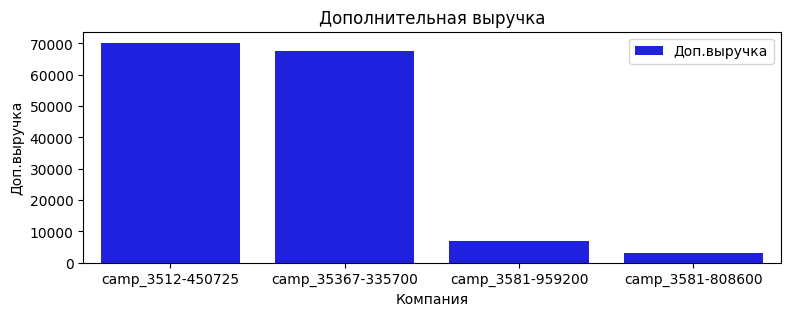

In [21]:
results['company'] = [f"{i[0]}-{i[1]}" for i in results.index.values]

figure, ax = plt.subplots(figsize=(9, 3))

sns.set_color_codes("muted")
sns.barplot(x='company', y='additional_revenue', data=results, label="Доп.выручка", color="blue")

ax.legend(ncol=1, loc="upper right", frameon=True)
plt.title('Дополнительная выручка')
plt.xlabel('Компания')
plt.ylabel('Доп.выручка')


plt.show()


#### Закрываем соединение

In [22]:
conn.close()

# Вывод:

Компания camp_3512 принесла наибольшую выручку <br>
Рекламная компания оказалась наиболее эфективная <br>
Разница в откликах Целевой группы и Контрольной группы оказалось значительно выше <br>
В итоге данная компание привлекла больше дополнительных клиентов <br>
Что в свою очередь отразилось на выручке